# FishFinder Model
The purpose of this model is to determine the offset locations and scale that allow a standard sized fovea that circumscribes the fish to be retreived.  

The FishNoF model will be transferred directly to this task, as the inputs are identical and tasks are similar (i.e. is a fish present or not versus where is the fish present).  There might be away to tie these tasks together, however I am unsure what to do about ... got it.

FishFinder will be a multitask model that detects whether a fish exists and the correct offsets for fish location with a scale for the image that will produce a standard sized fovea that encapsulates the fish. For `NoF` images, a weight of zero will be applied to the prediction of the offsets and scale.  Thus these images will not contribute to this task of learning.  All images will contribute to the learning of the FishNoF label, however weighting may also be used to aid in training efficiently against the unbalanced training set.   

#### Dependencies

In [1]:
import numpy as np
import tensorflow as tf
from importlib import reload
import os
import pickle
import fish_data as fd
from datetime import datetime

### Load label_dictionary.pickle
Dictionary will serve as a reference for filenames.

In [2]:
with open('label_dictionary.pickle', 'rb') as handle :
    label_dictionary = pickle.load(handle)

### Generate filenames lists for training and validation sets

In [3]:
master = fd.generate_filenames_list()
valid_fnames = []
train_fnames = [] 

for key in master :
    if label_dictionary.get(key).get('valid_set') == True :
        valid_fnames.append(key)
    else :
        train_fnames.append(key)

print("There are {} filenames in the training set".format(len(train_fnames)))
print("There are {} filenames in the validation set".format(len(valid_fnames)))


There are 3577 filenames in the training set
There are 200 filenames in the validation set


### Bundle Validation Coarse Image Array with Labels and Weights 

In [4]:
reload(fd)
help(fd.bundle_mt)

Help on function bundle_mt in module fish_data:

bundle_mt(f_list, label_dictionary, coarse_dims=[64, 112, 3], fov_dim=72)
    Generates an array of coarse images with corresponding labels from
    an input list of filenames.
    
    Returns :
        * coarse_arr - the array of coarse images (batch, y, x, channels).  Will
            need to be processed for network input.
        * is_fish - boolean array that describes whether a fish is present
            in the image
        * coords - float array ( [0,1]) that describes the position of
            the top left corner for a bounding box of the fish.
        * scale - array of floats.  Describes the scale for the high-resolution
            image, such that a bounding box that begins with the `coords` and
            extends in both the y and x directions for the number of pixels
            supplied by `fov_dim`, will produce a fovea that circumscribes the
            entire fish.
        * weights - weighting for coords / scale 

(200, 64, 112, 3) (200, 1)
First coarse image is Fish: [1]


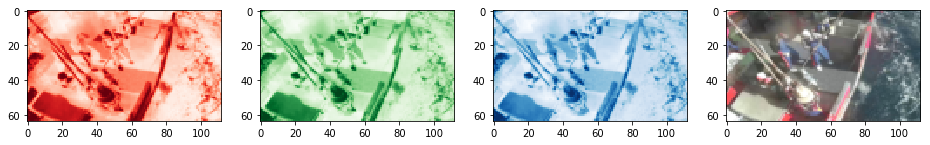

Valid Scales/Coords processed correctly : True
Valid Weights processed correctly : True


In [5]:

valid_coarse, valid_is_fish, valid_box, valid_weights = fd.bundle_mt(valid_fnames, label_dictionary = label_dictionary)
print(valid_coarse.shape, valid_is_fish.shape)
print("First coarse image is Fish: {}".format(valid_is_fish[0]))
fd.show_panel(valid_coarse[0, :, :, :])
print("Valid Scales/Coords processed correctly : {}".format(np.all(valid_box == -1)))
print("Valid Weights processed correctly : {}".format(np.all(valid_weights == 0)))

## Preprocess Validation Coarse Image Array

In [6]:
valid_coarse = valid_coarse.astype(np.float32)
print(np.mean(np.mean(np.mean(valid_coarse, axis =1), axis =1), axis = 0))
for i in range(valid_coarse.shape[0]) :
    valid_coarse[i,:, :, :] = fd.process_fovea(valid_coarse[i,:,:,:], pixel_norm = 'centre', mutation = False)

print(np.mean(np.mean(np.mean(valid_coarse, axis =1), axis =1), axis = 0))

[  97.24441528  108.08731079  104.71770477]
[ 0.76177758  0.88361704  4.7431531 ]


### Set-up and Parameters

In [7]:
version_ID = 'v1.0'
initiate_FishFinder = True 

wd = os.getcwd()
md = wd+'/FishFinder/'+version_ID
if not os.path.exists(md) :
    os.makedirs(md)
tensorboard_path = md+'/Tensorboard_logs'


In [8]:
%run -i 'FishFinder/FishFinder_PARAMS.py'

### Graph 

In [9]:
%run -i 'FishFinder/FishFinder_GRAPH.py'

### Session

In [10]:
%run -i 'FishFinder/FishFinder_SESSION.py'

Weight and bias variables initialized!

Checkpoint saver initialized!

Tensorboard initialized!
To view your tensorboard dashboard summary, run the following on the command line:

tensorboard --logdir='/Users/ccthomps/Documents/ML_Projects/Kaggle Competitions/FF3/FishFinder/v1.0/Tensorboard_logs'


TRAINING FishFinder_MT v1.0...
Batch Cost value: 0.222036
Batch Cost value: 0.305474
Batch Cost value: 0.177437
Batch Cost value: 0.161594
Batch Cost value: 0.182689
Batch Cost value: 0.186373
Batch Cost value: 0.179033
Batch Cost value: 0.135277
Batch Cost value: 0.1961
Batch Cost value: 0.155376
Batch Cost value: 0.179238
Epoch 1 completed : 3520 coarse images observed in 584.909482 s (6.457409421856491 images/sec). Model checkpoint created!
Batch Cost value: 0.218885
Batch Cost value: 0.18154
Batch Cost value: 0.199346
Batch Cost value: 0.12025
Batch Cost value: 0.153381
Batch Cost value: 0.185641
Batch Cost value: 0.157632
Batch Cost value: 0.160623
Batch Cost value: 0.158456
Batch Cost 

ValueError: all the input arrays must have same number of dimensions

In [15]:
label_dictionary.get('data/train/OTHER/img_07547.jpg')['scale'] = np.array([0.53333333333333333])

In [16]:
label_dictionary.get('data/train/OTHER/img_07547.jpg')['scale']

array([ 0.53333333])

In [17]:
with open('label_dictionary.pickle', 'wb') as fld :
    pickle.dump(label_dictionary, fld)

**NOTE:** Bug in label annotation function boxit.  Fixed in the master dictionary and fixed the bug in fish_data

In [18]:
initiate_FishFinder = False

In [19]:
%run -i 'FishFinder/FishFinder_SESSION.py'

Loading FishFinder_MT version v1.0
Metadata dictionary loaded!
Initializing restorer...
Weights and biases retrieved!  Picking up at 4 epochs completed : 14080 training images observed
Checkpoint saver initialized!

Tensorboard initialized!
To view your tensorboard dashboard summary, run the following on the command line:

tensorboard --logdir='/Users/ccthomps/Documents/ML_Projects/Kaggle Competitions/FF3/FishFinder/v1.0/Tensorboard_logs'


TRAINING FishFinder_MT v1.0...
Epoch 5 completed : 17600 coarse images observed in 507.58236 s (7.44115693855082 images/sec). Model checkpoint created!
Epoch 6 completed : 21120 coarse images observed in 501.771494 s (7.527330757454308 images/sec). Model checkpoint created!
Epoch 7 completed : 24640 coarse images observed in 504.510554 s (7.486463801508501 images/sec). Model checkpoint created!
Epoch 8 completed : 28160 coarse images observed in 513.128071 s (7.3607354839100205 images/sec). Model checkpoint created!
Epoch 9 completed : 31680 coarse 

**Note:** Raised the beta_rate to 0.8.  Because the ultimate goal of this model is to find the fish when they exist, decreasing the loss generated from the 'Fish' samples during the 'FishNoF' task is actually impeeding learning of the 2nd task.

In [25]:
%run -i 'FishFinder/FishFinder_SESSION.py'

Loading FishFinder_MT version v1.0
Metadata dictionary loaded!
Initializing restorer...
Weights and biases retrieved!  Picking up at 300 epochs completed : 1056000 training images observed
Checkpoint saver initialized!

Tensorboard initialized!
To view your tensorboard dashboard summary, run the following on the command line:

tensorboard --logdir='/Users/ccthomps/Documents/ML_Projects/Kaggle Competitions/FF3/FishFinder/v1.0/Tensorboard_logs'


TRAINING FishFinder_MT v1.0...
Epoch 301 completed : 1059520 coarse images observed in 488.156859 s (7.737267090207986 images/sec). Model checkpoint created!
Epoch 302 completed : 1063040 coarse images observed in 611.009697 s (6.181571288548634 images/sec). Model checkpoint created!
Epoch 303 completed : 1066560 coarse images observed in 472.806942 s (7.988461387692569 images/sec). Model checkpoint created!
Epoch 304 completed : 1070080 coarse images observed in 475.048652 s (7.950764588213167 images/sec). Model checkpoint created!
Epoch 305 co

**Note:**  Realized that mutation should not be used on this portion of training.  The bbox labels were not transformed in the same manner, and thus do not match the given images.  Also, upon further reading, I think I should keep the VGG convolution layers static.